# Testing Federation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup + Load Packages

Since Google Colab has pre-loaded packages, we have found that using our `requirements.txt` file can cause conflicts if we do not have a clean slate. However, running our file locally does require the installations in the file, so we present two options. Option 1 is for running this notebook on Google Colab (recommended) and Option 2 is for running this notebook locally (not recommended unless you have access to nice GPUs). The demo code should not take excessively long on a local machine, but it is much fast on Colab.

### Option 1

Assuming you have already mounted the git repo or uploaded the files to Google Drive, run the following two commands:

In [2]:
%pip install medmnist
%pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=53cda56d905fb41a3a758a53ccb8c694a02b4ec868a814ea4484ea6a05433ea1
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


These should (in theory) provide all the necessary packages for the notebook given the pre-installed packages.

### Option 2

On a local machine (preferably in a virtual environment) within the project folder, run:

In [ ]:
%pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


### For demo/normal use

Ensure you are in the `src` folder of the project

In [ ]:
%pwd

'/content'

In [ ]:
%cd OneFL/src

[Errno 2] No such file or directory: 'CAP_The-Federation_asj53_ctc92/src'
/content


In [ ]:
%cd /content/drive/MyDrive/OneFL

/content/drive/.shortcut-targets-by-id/1D1SxO5JoM4fHICMtrKkdp70SChR3NCos/CS4701_FL


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import fedisca
import train_loc
from train_loc import LocalTrainer
from resnet import ResNet50, ResNet18
import medmnist
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader
import numpy as np
import os
import utils
import matplotlib.pyplot as plt
from collections import Counter
from os import path

## Testing training of single local classifier

We use the entire dataset (in this case breastmnist) to train and validate a single local classifier. breastmnist is a small dataset with binary labels, so it is ideal for speed and testing.

In [ ]:
data_flag = 'breastmnist'
download = True

info = medmnist.INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

train_dataset = DataClass(split='train', download=download)
val_dataset = DataClass(split='val', download=download)
test_dataset = DataClass(split='test', download=download)

100%|██████████| 560k/560k [00:00<00:00, 742kB/s]

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


In [ ]:
aug_list = []
aug_list.append(transforms.RandomCrop(28, padding=4))
aug_list.append(transforms.RandomHorizontalFlip())
preprocess_list = [transforms.ToTensor(), transforms.Normalize(mean=[.5], std=[.5])]

In [ ]:
loc_trainer_test = LocalTrainer(ResNet18(in_channels=1, num_classes=2), DataClass, "./loc_model_weights", n_classes, epochs=100,  aug=aug_list, preprocess=preprocess_list, seed=42)

In [ ]:
loc_trainer_test.train()

Epoch num: 1 
Train loss: 0.044679 
Val loss: 0.012910 
Val acc: 0.294872
Val balanced acc: 0.502506
Epoch num: 2 
Train loss: 0.024906 
Val loss: 0.169277 
Val acc: 0.384615
Val balanced acc: 0.548872
Epoch num: 3 
Train loss: 0.021689 
Val loss: 0.027551 
Val acc: 0.730769
Val balanced acc: 0.500000
Epoch num: 4 
Train loss: 0.022055 
Val loss: 0.016711 
Val acc: 0.730769
Val balanced acc: 0.515038
Epoch num: 5 
Train loss: 0.020043 
Val loss: 0.007733 
Val acc: 0.717949
Val balanced acc: 0.686717
Epoch num: 6 
Train loss: 0.019952 
Val loss: 0.007710 
Val acc: 0.679487
Val balanced acc: 0.494987
Epoch num: 7 
Train loss: 0.018884 
Val loss: 0.006889 
Val acc: 0.782051
Val balanced acc: 0.625313
Epoch num: 8 
Train loss: 0.019230 
Val loss: 0.006835 
Val acc: 0.743590
Val balanced acc: 0.614035
Epoch num: 9 
Train loss: 0.018679 
Val loss: 0.006311 
Val acc: 0.769231
Val balanced acc: 0.691729
Epoch num: 10 
Train loss: 0.017160 
Val loss: 0.006435 
Val acc: 0.769231
Val balanced acc

In [ ]:
# Load the best performing model (assuming it was saved during training).
loc_trainer_test.load_model("./loc_model_weights/best.pth") # Replace with the actual path if different

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])
test_data = DataClass(split='test', transform=test_transforms, download=False)
test_loader = DataLoader(dataset=test_data, batch_size=128, shuffle=False, num_workers=0)

# Evaluate the model on the test dataset.
test_loss, test_acc, test_bacc = loc_trainer_test.validate(test_loader)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test Loss: 0.0059
Test Accuracy: 0.8397


/content/CAP_The-Federation_asj53_ctc92/src/train_loc.py:197: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.state_dict = torch.load(path)


## Testing data partition for federation sims

We test the data partition method `utils.fl_partition` by verifying the splits are visually i.i.d (class balance matches, partition size is equal) when the i.i.d partition is specified and visually non i.i.d when it is not supposed to be. We use `pathmnist`, which has 9 classes.

In [ ]:
data_flag = 'pathmnist'
download = True

info = medmnist.INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])
train_dataset = DataClass(root="./", split='train', download=download)

train_dataset

100%|██████████| 206M/206M [00:11<00:00, 18.2MB/s]


Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 89996
    Root location: ./
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into trainin

We plot the distribution of labels of the original dataset. We use chatgpt to assist in the coding of this visualization using the prompt:

"Given a list of labels, plot the distribution of the labels using python and matplotlib"

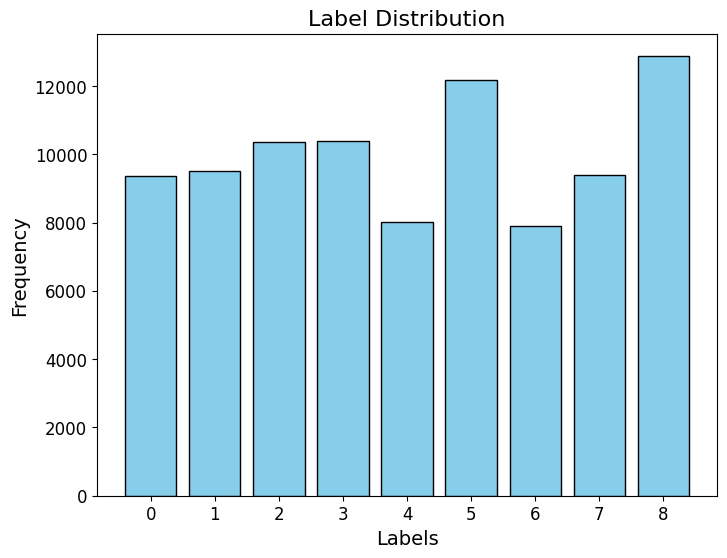

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Example list of labels
labels = train_dataset.labels.flatten().tolist()

# Count the frequency of each label
label_counts = Counter(labels)

# Extract labels and their counts
categories = list(label_counts.keys())
counts = list(label_counts.values())

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Label Distribution', fontsize=16)
plt.xticks(ticks = categories, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

Next, we test an i.i.d partition into 5 datasets and check if each of them display a similar distribution over the labels.

In [ ]:
import utils
import numpy as np

In [ ]:
part_dir, list_name, split_ids = utils.fl_partition(train_dataset, 5, 9, seed=42)

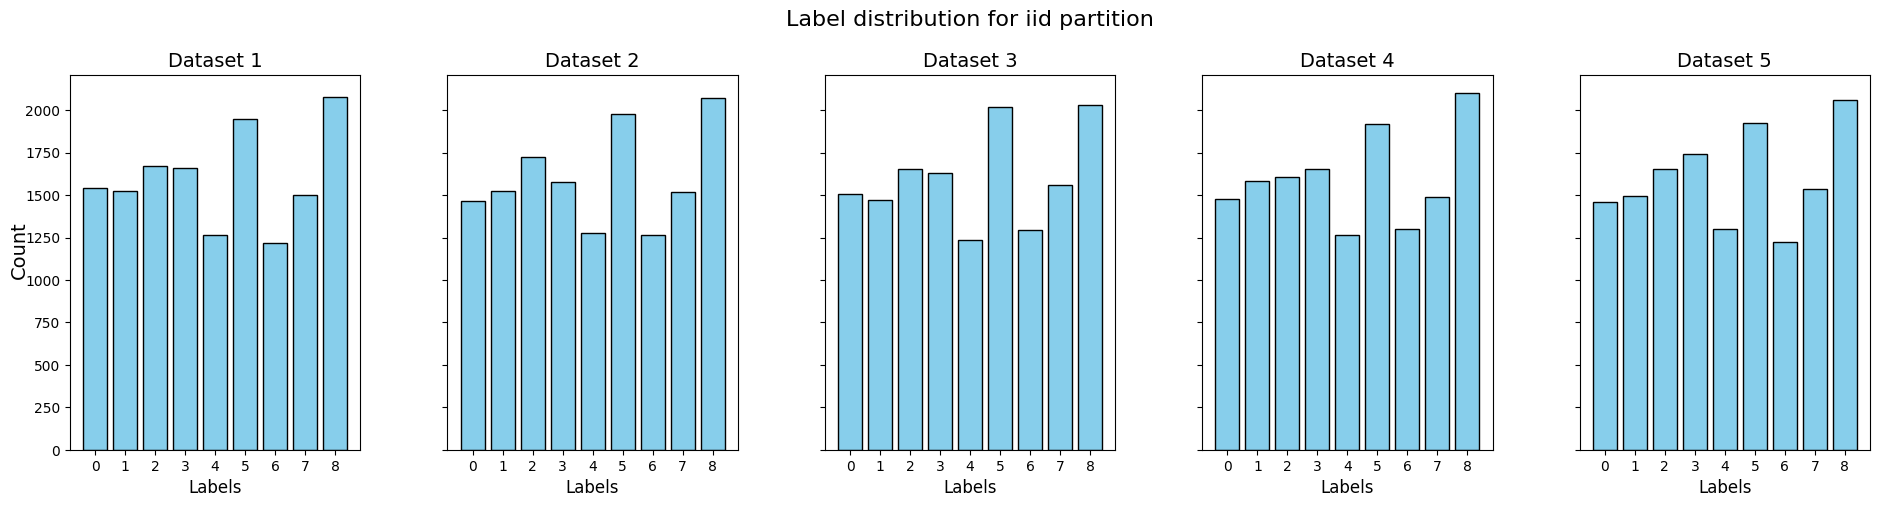

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

for list_ind, ax in enumerate(axes):
    f_name = list_name[list_ind]
    data = np.load(f_name)
    labels = data['train_labels'].flatten().tolist()
    label_counts = Counter(labels)
    categories = list(label_counts.keys())
    counts = list(label_counts.values())

    # Plot on the current subplot
    ax.bar(categories, counts, color='skyblue', edgecolor='black')
    ax.set_title(f"Dataset {list_ind + 1}", fontsize=14)
    ax.set_xlabel('Labels', fontsize=12)
    ax.set_xticks(ticks=categories)
    ax.tick_params(axis='y', labelsize=10)

fig.supylabel('Count', fontsize=14)
fig.suptitle('Label distribution for iid partition', fontsize=16)
fig.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.1, wspace=0.3)
#plt.tight_layout()

plt.show()


Next, we want to make sure the dirichlet non-i.i.d splits are visually heterogenous.

In [ ]:
part_dir, list_name, split_ids = utils.fl_partition(train_dataset, 5, 10, beta=0.5, iid=False, min_size=1000, seed=42)

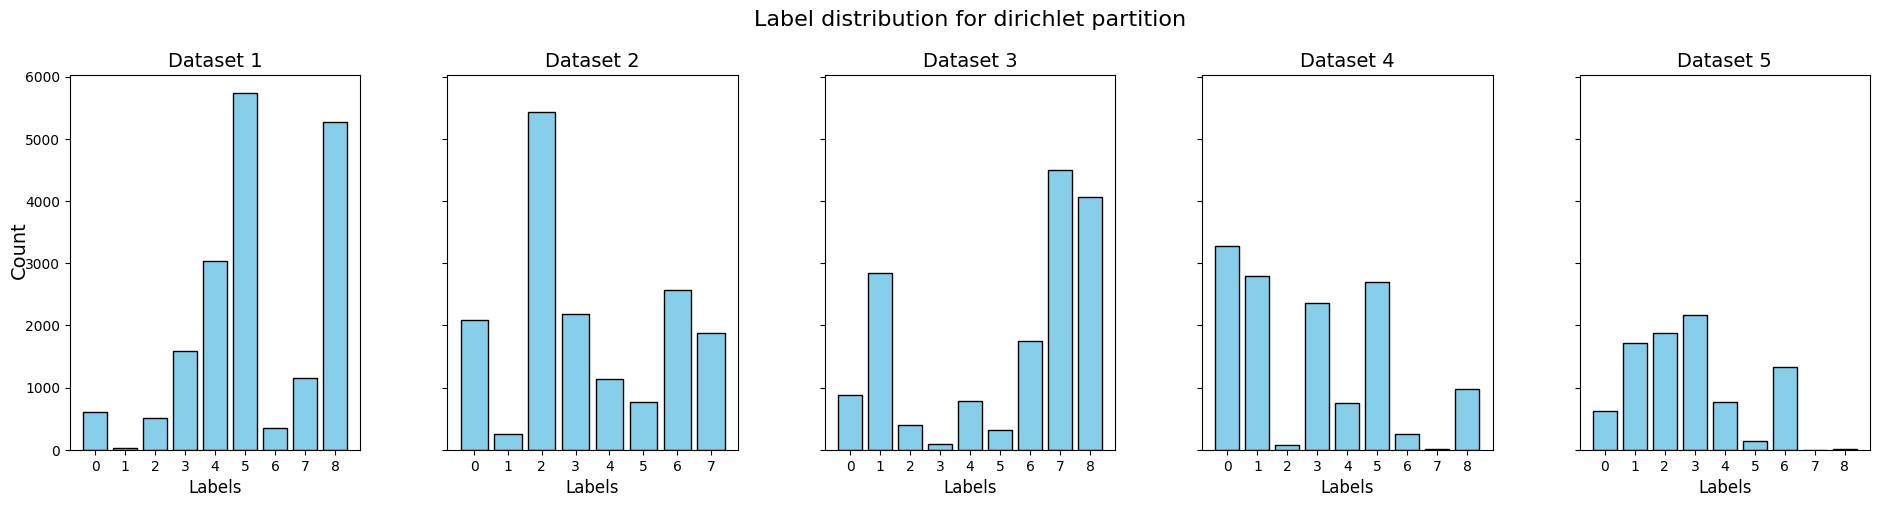

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

for list_ind, ax in enumerate(axes):
    f_name = list_name[list_ind]
    data = np.load(f_name)
    labels = data['train_labels'].flatten().tolist()
    label_counts = Counter(labels)
    categories = list(label_counts.keys())
    counts = list(label_counts.values())

    # Plot on the current subplot
    ax.bar(categories, counts, color='skyblue', edgecolor='black')
    ax.set_title(f"Dataset {list_ind + 1}", fontsize=14)
    ax.set_xlabel('Labels', fontsize=12)
    ax.set_xticks(ticks=categories)
    ax.tick_params(axis='y', labelsize=10)

fig.supylabel('Count', fontsize=14)
fig.suptitle('Label distribution for dirichlet partition', fontsize=16)
fig.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.1, wspace=0.3)
#plt.tight_layout()

plt.show()


## Testing FedISCA on i.i.d. data

We need to test 3 different steps.

1. Partition data in iid fashion
2. Train local models on each partition of the data
3. Federate local models with FedISCA

1. Partition iid

In [ ]:
data_flag = 'bloodmnist'
download = True

info = medmnist.INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])
glb_train_dataset = DataClass(root="./", split='train', download=download)
glb_val_dataset = DataClass(root="./", split='val', download=download)
glb_test_dataset = DataClass(root="./", split='test', download=download)
info["n_samples"]["train"] = glb_train_dataset.imgs.shape[0]
info["n_samples"]["val"] = glb_val_dataset.imgs.shape[0]
info["n_samples"]["test"] = glb_test_dataset.imgs.shape[0]
glb_train_dataset

Using downloaded and verified file: ./bloodmnist.npz
Using downloaded and verified file: ./bloodmnist.npz
Using downloaded and verified file: ./bloodmnist.npz


Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 11959
    Root location: ./
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC BY 4.0

In [ ]:
num_clients = 5
num_classes = 8
part_dir, list_name, split_ids = utils.fl_partition(glb_train_dataset, data_flag, num_clients, num_classes, seed=42)

In [ ]:
print(part_dir)

pathmnist_expr/sim_partitions_iid


2. Train local models on each partition of the data

In [ ]:
data_flag = 'bloodmnist'

info = medmnist.INFO[data_flag].copy()
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

for i in range(num_clients):
    DataClass = getattr(medmnist, info['python_class'])
    root = os.path.join(part_dir, "client_" + str(i))
    train_dataset = DataClass(root=os.path.join(part_dir, "client_" + str(i)), split='train', download=False)
    val_dataset = DataClass(root=os.path.join(part_dir, "client_" + str(i)), split='val', download=False)
    info = medmnist.INFO[data_flag].copy()
    train_dataset.info = info
    val_dataset.info = info
    train_dataset.info["n_samples"]["train"] = train_dataset.imgs.shape[0]
    val_dataset.info["n_samples"]["val"] = val_dataset.imgs.shape[0]
    #TODO NEED TO FIX THIS INFO SAMPLE SIZE ISSUE
    # train_dataset.info["n_samples"]["test"] = 0

    aug_list = []
    aug_list.append(transforms.RandomCrop(28, padding=4))
    aug_list.append(transforms.RandomHorizontalFlip())
    preprocess_list = [transforms.ToTensor(), transforms.Normalize(mean=[.5], std=[.5])]

    loc_trainer_test = LocalTrainer(ResNet18(in_channels=3, num_classes=8), DataClass, os.path.join("blood_models", "client_" + str(i)), n_classes, root=root, epochs=100, lr_adj = [10, 15], aug=aug_list, preprocess=preprocess_list, seed=i)
    loc_trainer_test.train()

Epoch num: 1 
Train loss: 0.171415 
Val loss: 0.036534 
Val acc: 0.313808
Val balanced acc: 0.320942
Epoch num: 2 
Train loss: 0.087063 
Val loss: 0.010793 
Val acc: 0.631799
Val balanced acc: 0.598843
Epoch num: 3 
Train loss: 0.070358 
Val loss: 0.010469 
Val acc: 0.602510
Val balanced acc: 0.628109
Epoch num: 4 
Train loss: 0.065630 
Val loss: 0.028277 
Val acc: 0.336820
Val balanced acc: 0.378057
Epoch num: 5 
Train loss: 0.056386 
Val loss: 0.004226 
Val acc: 0.824268
Val balanced acc: 0.775830
Epoch num: 6 
Train loss: 0.051509 
Val loss: 0.005905 
Val acc: 0.728033
Val balanced acc: 0.681233
Epoch num: 7 
Train loss: 0.051523 
Val loss: 0.012275 
Val acc: 0.589958
Val balanced acc: 0.490417
Epoch num: 8 
Train loss: 0.053366 
Val loss: 0.008233 
Val acc: 0.690377
Val balanced acc: 0.601304
Epoch num: 9 
Train loss: 0.046794 
Val loss: 0.008647 
Val acc: 0.640167
Val balanced acc: 0.608475
Epoch num: 10 
Train loss: 0.044380 
Val loss: 0.004139 
Val acc: 0.832636
Val balanced acc

3. Federate Models

For **demo 2**, we use the global test set as the metric for federation. In future experiements, we will test on the individual validation sets as well.

In [ ]:
FedBlood = fedisca.FedISCA(test_data_dir="./", model_weights_dir="./blood_models", exper_dir="./blood_exper/federated", input_size=28, in_channels=3, num_classes=8, batch_size=64, epochs=25, iter_mi=500, lr_steps=[15, 20], log_freq=25, is_medmnist=True, medmnist="bloodmnist")
ens_local = FedBlood.load_models()

{'python_class': 'BloodMNIST', 'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.', 'url': 'https://zenodo.org/records/10519652/files/bloodmnist.npz?download=1', 'MD5': '7053d0359d879ad8a5505303e11de1dc', 'url_64': 'https://zenodo.org/records/10519652/files/bloodmnist_64.npz?download=1', 'MD5_64': '2b94928a2ae4916078ca51e05b6b800b', 'url_128': 'https://zenodo.org/records/10519652/files/bloodmnist_128.npz?download=1', 'MD5_128': 'adace1e0ed228fccda1f39692059dd4c', 'url_224': 'https://zenodo.org/records/10519652/files/bloodmnist_224.npz

In [ ]:
fed_model, noise_adapt = FedBlood.model_inversion(ens_local, large_jtr=5, small_jtr=2)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
        0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
        0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7], device='cuda:0')
Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 3421
    Root location: .
    Split: test
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 1913, 'val': 478, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split

In [ ]:
%cd ../

/content/drive/.shortcut-targets-by-id/1D1SxO5JoM4fHICMtrKkdp70SChR3NCos/CS4701_FL


In [44]:
import torch.nn as nn
#fed_model = ResNet18(in_channels=3, num_classes=8)
#fed_model.to('cuda')
fed_model = torch.load("./blood_exper/federated/glb_model_last.pth")

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])
test_data = DataClass(split='test', root="./", transform=test_transforms, download=False)
test_loader = DataLoader(dataset=test_data, batch_size=128, shuffle=False, num_workers=0)

FedBlood.test_model(fed_model, test_loader, nn.CrossEntropyLoss())

<ipython-input-44-eac6e1f1ecab>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fed_model = torch.load("./blood_exper/federated/glb_model_last.pth")


tensor([6, 5, 3, 5, 3, 3, 2, 5, 2, 3, 7, 6, 5, 6, 1, 6, 3, 3, 6, 1, 6, 2, 1, 1,
        3, 1, 0, 6, 6, 4, 2, 1, 6, 6, 1, 2, 4, 1, 7, 4, 2, 7, 7, 1, 1, 6, 5, 3,
        6, 1, 6, 3, 3, 7, 1, 7, 3, 7, 4, 6, 6, 6, 6, 1, 3, 4, 7, 0, 1, 7, 3, 1,
        2, 6, 7, 1, 1, 1, 7, 3, 2, 3, 3, 6, 3, 3, 5, 4, 6, 3, 3, 1, 7],
       device='cuda:0')
Loss: 0.325 | Acc: 89.360% (3057/3421), B. Acc: 0.857%


(8.774762317538261, 0.8935983630517392, 0.8570388553931055)

In [51]:
client_0_weights = torch.load("./blood_models/client_4/best.pth")
client_0_model = ResNet18(in_channels=3, num_classes=8)
client_0_model.load_state_dict(client_0_weights)
client_0_model.to('cuda')
FedBlood.test_model(client_0_model, test_loader, nn.CrossEntropyLoss())

<ipython-input-51-65a36cce6aaa>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  client_0_weights = torch.load("./blood_models/client_4/best.pth")


tensor([6, 5, 4, 5, 3, 3, 2, 5, 2, 3, 7, 6, 5, 3, 1, 6, 0, 3, 6, 1, 6, 2, 1, 1,
        3, 1, 0, 6, 6, 4, 2, 1, 6, 6, 1, 2, 4, 1, 7, 4, 2, 7, 7, 1, 1, 6, 5, 3,
        6, 1, 6, 3, 0, 7, 1, 7, 3, 7, 4, 6, 6, 6, 6, 1, 3, 4, 7, 0, 1, 7, 3, 1,
        2, 6, 7, 1, 1, 1, 7, 3, 2, 3, 5, 6, 3, 3, 5, 4, 6, 3, 3, 1, 7],
       device='cuda:0')
Loss: 0.227 | Acc: 93.803% (3209/3421), B. Acc: 0.930%


(6.1330351755023, 0.9380298158433207, 0.9301921356667815)

## Testing on non-iid data

In [7]:
data_flag = 'bloodmnist'
download = True

info = medmnist.INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])
glb_train_dataset = DataClass(root="./", split='train', download=download)
glb_val_dataset = DataClass(root="./", split='val', download=download)
glb_test_dataset = DataClass(root="./", split='test', download=download)
info["n_samples"]["train"] = glb_train_dataset.imgs.shape[0]
info["n_samples"]["val"] = glb_val_dataset.imgs.shape[0]
info["n_samples"]["test"] = glb_test_dataset.imgs.shape[0]
glb_train_dataset

Using downloaded and verified file: ./bloodmnist.npz
Using downloaded and verified file: ./bloodmnist.npz
Using downloaded and verified file: ./bloodmnist.npz


Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 11959
    Root location: ./
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC BY 4.0

In [9]:
num_clients = 5
num_classes = 8
part_dir, list_name, split_ids = utils.fl_partition(glb_train_dataset, data_flag, num_clients, num_classes, iid=False, beta=1, val_split = 0.2, seed=42)

2539

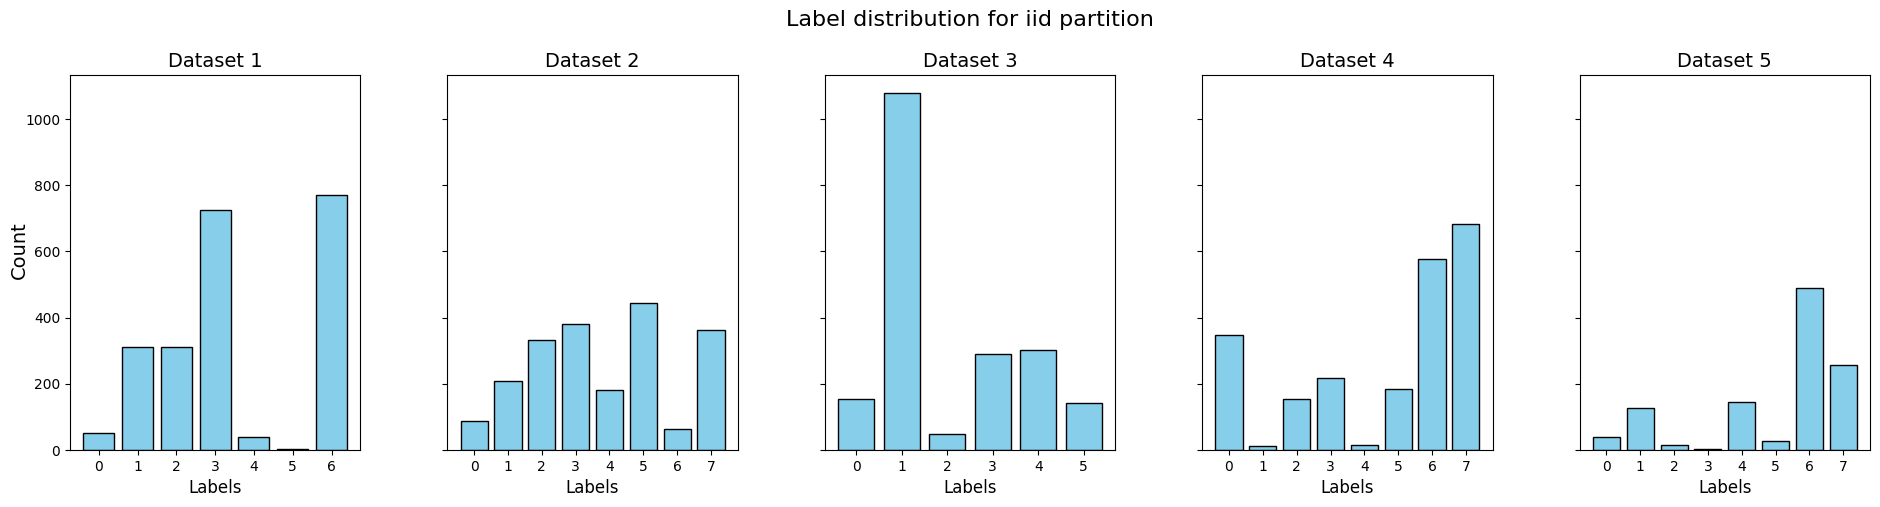

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

for list_ind, ax in enumerate(axes):
    f_name = list_name[list_ind]
    data = np.load(f_name)
    labels = data['train_labels'].flatten().tolist()
    label_counts = Counter(labels)
    categories = list(label_counts.keys())
    counts = list(label_counts.values())

    # Plot on the current subplot
    ax.bar(categories, counts, color='skyblue', edgecolor='black')
    ax.set_title(f"Dataset {list_ind + 1}", fontsize=14)
    ax.set_xlabel('Labels', fontsize=12)
    ax.set_xticks(ticks=categories)
    ax.tick_params(axis='y', labelsize=10)

fig.supylabel('Count', fontsize=14)
fig.suptitle('Label distribution for iid partition', fontsize=16)
fig.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.1, wspace=0.3)
#plt.tight_layout()

plt.show()


In [ ]:
data_flag = 'bloodmnist'

info = medmnist.INFO[data_flag].copy()
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

for i in range(num_clients):
    DataClass = getattr(medmnist, info['python_class'])
    root = os.path.join(part_dir, "client_" + str(i))
    train_dataset = DataClass(root=os.path.join(part_dir, "client_" + str(i)), split='train', download=False)
    val_dataset = DataClass(root=os.path.join(part_dir, "client_" + str(i)), split='val', download=False)
    info = medmnist.INFO[data_flag].copy()
    train_dataset.info = info
    val_dataset.info = info
    train_dataset.info["n_samples"]["train"] = train_dataset.imgs.shape[0]
    val_dataset.info["n_samples"]["val"] = val_dataset.imgs.shape[0]
    #TODO NEED TO FIX THIS INFO SAMPLE SIZE ISSUE
    # train_dataset.info["n_samples"]["test"] = 0

    aug_list = []
    aug_list.append(transforms.RandomCrop(28, padding=4))
    aug_list.append(transforms.RandomHorizontalFlip())
    preprocess_list = [transforms.ToTensor(), transforms.Normalize(mean=[.5], std=[.5])]

    loc_trainer_test = LocalTrainer(ResNet18(in_channels=3, num_classes=8), DataClass, os.path.join("blood_models_dirich", "client_" + str(i)), n_classes, root=root, epochs=50, lr_adj = [25, 40], aug=aug_list, preprocess=preprocess_list, seed=i)
    loc_trainer_test.train()

Epoch num: 1 
Train loss: 0.186484 
Val loss: 0.014164 
Val acc: 0.493097
Val balanced acc: 0.307373
Epoch num: 2 
Train loss: 0.126273 
Val loss: 0.015852 
Val acc: 0.558185
Val balanced acc: 0.330379
Epoch num: 3 
Train loss: 0.093666 
Val loss: 0.014422 
Val acc: 0.532544
Val balanced acc: 0.302713
Epoch num: 4 
Train loss: 0.078253 
Val loss: 0.008027 
Val acc: 0.656805
Val balanced acc: 0.650062
Epoch num: 5 
Train loss: 0.072732 
Val loss: 0.008086 
Val acc: 0.690335
Val balanced acc: 0.595264
Epoch num: 6 
Train loss: 0.067362 
Val loss: 0.004627 
Val acc: 0.790927
Val balanced acc: 0.792062
Epoch num: 7 
Train loss: 0.060546 
Val loss: 0.004303 
Val acc: 0.783037
Val balanced acc: 0.789860
Epoch num: 8 
Train loss: 0.061448 
Val loss: 0.019181 
Val acc: 0.469428
Val balanced acc: 0.439182
Epoch num: 9 
Train loss: 0.058768 
Val loss: 0.011673 
Val acc: 0.593688
Val balanced acc: 0.569991
Epoch num: 10 
Train loss: 0.052053 
Val loss: 0.004240 
Val acc: 0.796844
Val balanced acc

In [10]:
FedBlood = fedisca.FedISCA(test_data_dir="./", model_weights_dir="./blood_models_dirich", exper_dir="./blood_exper_dirich/federated", input_size=28, in_channels=3, num_classes=8, batch_size=128, epochs=25, iter_mi=500, lr_steps=[16, 20], log_freq=100, is_medmnist=True, medmnist="bloodmnist")
ens_local = FedBlood.load_models()

{'python_class': 'BloodMNIST', 'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.', 'url': 'https://zenodo.org/records/10519652/files/bloodmnist.npz?download=1', 'MD5': '7053d0359d879ad8a5505303e11de1dc', 'url_64': 'https://zenodo.org/records/10519652/files/bloodmnist_64.npz?download=1', 'MD5_64': '2b94928a2ae4916078ca51e05b6b800b', 'url_128': 'https://zenodo.org/records/10519652/files/bloodmnist_128.npz?download=1', 'MD5_128': 'adace1e0ed228fccda1f39692059dd4c', 'url_224': 'https://zenodo.org/records/10519652/files/bloodmnist_224.npz

In [60]:
fed_model, noise_adapt = FedBlood.model_inversion(ens_local, large_jtr=5, small_jtr=2)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
        0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
        0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
        0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
        0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7,
        0, 1, 2, 3, 4, 5, 6, 7], device='cuda:0')
Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 3421
    Root location: .
    Split: test
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from

In [11]:
import torch.nn as nn
fed_model = torch.load("./blood_exper_dirich/federated/glb_model_last.pth")
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])
test_data = DataClass(split='test', root="./", transform=test_transforms, download=False)
test_loader = DataLoader(dataset=test_data, batch_size=128, shuffle=False, num_workers=0)

FedBlood.test_model(fed_model, test_loader, nn.CrossEntropyLoss())

<ipython-input-11-e8709b84d129>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fed_model = torch.load("./blood_exper_dirich/federated/glb_model_last.pth")


tensor([6, 5, 4, 5, 3, 5, 2, 5, 2, 3, 2, 6, 5, 2, 1, 6, 5, 3, 6, 1, 6, 2, 1, 1,
        0, 1, 0, 6, 6, 4, 5, 1, 6, 6, 1, 2, 4, 1, 2, 4, 2, 2, 2, 1, 1, 3, 5, 3,
        6, 1, 6, 3, 0, 2, 1, 2, 3, 2, 4, 6, 6, 6, 6, 1, 5, 4, 2, 0, 1, 2, 5, 1,
        2, 6, 2, 1, 1, 1, 2, 3, 2, 3, 5, 6, 5, 5, 5, 4, 6, 3, 3, 1, 2],
       device='cuda:0')
Loss: 1.482 | Acc: 74.540% (2550/3421), B. Acc: 0.757%


(40.02048659324646, 0.7453960830166618, 0.7572539449632514)

In [17]:
client_0_weights = torch.load("./blood_models_dirich/client_4/best.pth")
client_0_model = ResNet18(in_channels=3, num_classes=8)
client_0_model.load_state_dict(client_0_weights)
client_0_model.to('cuda')
FedBlood.test_model(client_0_model, test_loader, nn.CrossEntropyLoss())

<ipython-input-17-d8dc6215a129>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  client_0_weights = torch.load("./blood_models_dirich/client_4/best.pth")


tensor([6, 3, 4, 3, 3, 3, 2, 3, 2, 3, 2, 6, 5, 3, 1, 6, 3, 3, 6, 1, 6, 2, 1, 1,
        3, 1, 0, 6, 6, 4, 3, 1, 6, 6, 1, 2, 4, 1, 2, 4, 2, 2, 2, 1, 1, 6, 5, 3,
        6, 1, 6, 3, 4, 2, 1, 6, 3, 2, 4, 6, 6, 6, 6, 1, 3, 4, 2, 0, 1, 2, 3, 1,
        2, 6, 6, 1, 1, 1, 2, 3, 2, 3, 3, 6, 3, 3, 3, 4, 6, 3, 3, 1, 2],
       device='cuda:0')
Loss: 2.515 | Acc: 74.920% (2563/3421), B. Acc: 0.718%


(67.91163086891174, 0.7491961414790996, 0.7178466353954271)

## Pneumonia dirich

In [86]:
data_flag = 'pneumoniamnist'
download = True

info = medmnist.INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])
glb_train_dataset = DataClass(root="./", split='train', download=download)
glb_val_dataset = DataClass(root="./", split='val', download=download)
glb_test_dataset = DataClass(root="./", split='test', download=download)
info["n_samples"]["train"] = glb_train_dataset.imgs.shape[0]
info["n_samples"]["val"] = glb_val_dataset.imgs.shape[0]
info["n_samples"]["test"] = glb_test_dataset.imgs.shape[0]
glb_train_dataset

Using downloaded and verified file: ./pneumoniamnist.npz
Using downloaded and verified file: ./pneumoniamnist.npz
Using downloaded and verified file: ./pneumoniamnist.npz


Dataset PneumoniaMNIST of size 28 (pneumoniamnist)
    Number of datapoints: 4708
    Root location: ./
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0

In [87]:
num_clients = 5
num_classes = 2
part_dir, list_name, split_ids = utils.fl_partition(glb_train_dataset, data_flag, num_clients, num_classes, iid=False, beta=0.6, val_split = 0.2, seed=42)

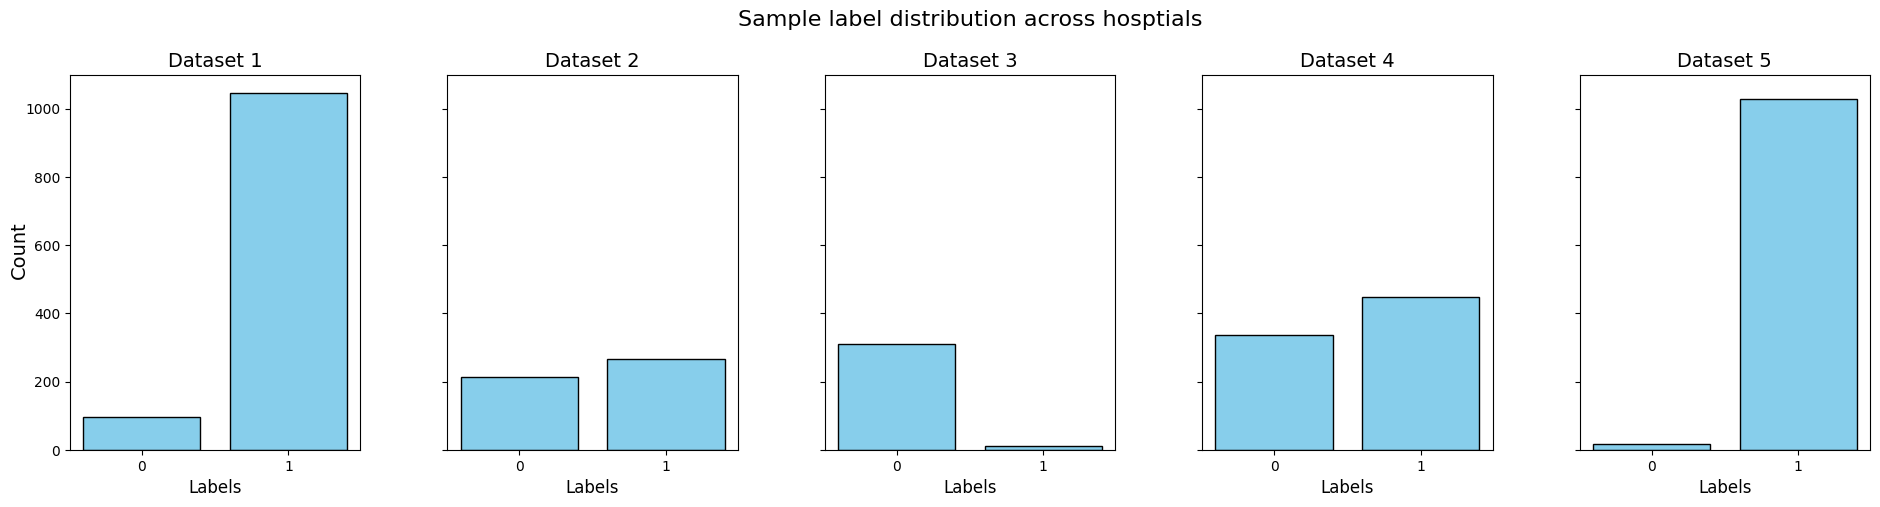

In [88]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

for list_ind, ax in enumerate(axes):
    f_name = list_name[list_ind]
    data = np.load(f_name)
    labels = data['train_labels'].flatten().tolist()
    label_counts = Counter(labels)
    categories = list(label_counts.keys())
    counts = list(label_counts.values())

    # Plot on the current subplot
    ax.bar(categories, counts, color='skyblue', edgecolor='black')
    ax.set_title(f"Dataset {list_ind + 1}", fontsize=14)
    ax.set_xlabel('Labels', fontsize=12)
    ax.set_xticks(ticks=categories)
    ax.tick_params(axis='y', labelsize=10)

fig.supylabel('Count', fontsize=14)
fig.suptitle('Sample label distribution across hosptials', fontsize=16)
fig.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.1, wspace=0.3)
#plt.tight_layout()

plt.show()


In [89]:
data_flag = 'pneumoniamnist'

info = medmnist.INFO[data_flag].copy()
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

for i in range(num_clients):
    DataClass = getattr(medmnist, info['python_class'])
    root = os.path.join(part_dir, "client_" + str(i))
    train_dataset = DataClass(root=os.path.join(part_dir, "client_" + str(i)), split='train', download=False)
    val_dataset = DataClass(root=os.path.join(part_dir, "client_" + str(i)), split='val', download=False)
    info = medmnist.INFO[data_flag].copy()
    train_dataset.info = info
    val_dataset.info = info
    train_dataset.info["n_samples"]["train"] = train_dataset.imgs.shape[0]
    val_dataset.info["n_samples"]["val"] = val_dataset.imgs.shape[0]
    #TODO NEED TO FIX THIS INFO SAMPLE SIZE ISSUE
    # train_dataset.info["n_samples"]["test"] = 0

    aug_list = []
    aug_list.append(transforms.RandomCrop(28, padding=4))
    aug_list.append(transforms.RandomHorizontalFlip())
    preprocess_list = [transforms.ToTensor(), transforms.Normalize(mean=[.5], std=[.5])]

    loc_trainer_test = LocalTrainer(ResNet18(in_channels=n_channels, num_classes=n_classes), DataClass, os.path.join("pneumonia_models_dirich", "client_" + str(i)), n_classes, root=root, epochs=50, lr_adj = [25, 40], aug=aug_list, preprocess=preprocess_list, seed=i)
    loc_trainer_test.train()

Epoch num: 1 
Train loss: 0.031312 
Val loss: 0.003676 
Val acc: 0.901754
Val balanced acc: 0.500000
Epoch num: 2 
Train loss: 0.019240 
Val loss: 0.009736 
Val acc: 0.901754
Val balanced acc: 0.500000
Epoch num: 3 
Train loss: 0.009629 
Val loss: 0.010799 
Val acc: 0.901754
Val balanced acc: 0.500000
Epoch num: 4 
Train loss: 0.009805 
Val loss: 0.003073 
Val acc: 0.919298
Val balanced acc: 0.589286
Epoch num: 5 
Train loss: 0.007262 
Val loss: 0.000540 
Val acc: 0.968421
Val balanced acc: 0.902932
Epoch num: 6 
Train loss: 0.006611 
Val loss: 0.002214 
Val acc: 0.929825
Val balanced acc: 0.642857
Epoch num: 7 
Train loss: 0.007374 
Val loss: 0.003549 
Val acc: 0.915789
Val balanced acc: 0.571429
Epoch num: 8 
Train loss: 0.007490 
Val loss: 0.000601 
Val acc: 0.971930
Val balanced acc: 0.873054
Epoch num: 9 
Train loss: 0.006233 
Val loss: 0.001256 
Val acc: 0.943860
Val balanced acc: 0.937048
Epoch num: 10 
Train loss: 0.006137 
Val loss: 0.000822 
Val acc: 0.961404
Val balanced acc

In [63]:
FedPneu = fedisca.FedISCA(test_data_dir="./", model_weights_dir="./pneumonia_models_dirich", exper_dir="./pneumonnia_exper_dirich/federated", input_size=28, in_channels=n_channels, num_classes=n_classes, batch_size=64, epochs=25, iter_mi=500, lr_steps=[16, 20], log_freq=100, is_medmnist=True, medmnist="pneumoniamnist")
ens_local = FedPneu.load_models()

{'python_class': 'PneumoniaMNIST', 'description': 'The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.', 'url': 'https://zenodo.org/records/10519652/files/pneumoniamnist.npz?download=1', 'MD5': '28209eda62fecd6e6a2d98b1501bb15f', 'url_64': 'https://zenodo.org/records/10519652/files/pneumoniamnist_64.npz?download=1', 'MD5_64': '8f4eceb4ccffa70c672198ea285246c6', 'url_128': 'https://zenodo.org/records/10519652/files/pneumoniamnist_128.npz?download=1', 'MD5_128': '05b46931834c231683c68f40c47b2971', 'url_224': 'https://zenodo.org/records/10519652/files/pneumoniamnist_224.npz?download=1', 'MD5_224': 'd6a3c71de1b945ea11211b

In [64]:
fed_model, noise_adapt = FedPneu.model_inversion(ens_local, large_jtr=5, small_jtr=2)

tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
Dataset PneumoniaMNIST of size 28 (pneumoniamnist)
    Number of datapoints: 624
    Root location: .
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Generating 

In [47]:
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])
test_data = DataClass(split='test', root="./", transform=test_transforms, download=False)
test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False, num_workers=0)

In [103]:
import torch.nn as nn
fed_model = torch.load("pneumonnia_exper_dirich/federated/best.pth")
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])
test_data = DataClass(split='test', root="./", transform=test_transforms, download=False)
test_loader = DataLoader(dataset=test_data, batch_size=128, shuffle=False, num_workers=0)

FedPneu.test_model(fed_model, test_loader, nn.CrossEntropyLoss())

<ipython-input-103-9122802a47ef>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fed_model = torch.load("pneumonnia_exper_dirich/federated/best.pth")


Loss: 0.473 | Acc: 83.333% (520/624), B. Acc: 78.291%


(2.3642348647117615, 0.8333333333333334, 0.782905982905983)

In [106]:
client_0_weights = torch.load("./pneumonia_models_dirich/client_1/best.pth")
client_0_model = ResNet18(in_channels=1, num_classes=2)
client_0_model.load_state_dict(client_0_weights)
client_0_model.to('cuda')
FedPneu.test_model(client_0_model, test_loader, nn.CrossEntropyLoss())

<ipython-input-106-afad4c0a4322>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  client_0_weights = torch.load("./pneumonia_models_dirich/client_1/best.pth")


Loss: 0.340 | Acc: 88.301% (551/624), B. Acc: 87.051%


(1.7001046538352966, 0.8830128205128205, 0.8705128205128205)